In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ripser
import statistics
import utility
import random
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
%load_ext autoreload
%autoreload 2

In [49]:
seed = 1998
random.seed(seed)

In [3]:
def sigmoid(x, A, B, C):
    return B/(1+np.exp(A*(x-C)))+1
def gaussian(x, D, E, F):
    return D*np.exp(-((x-F)/E)**2)
def new_gaussian(x, D, E, F):
    return np.exp(-((x-F)/E)**2 + D)
def logarithm(x, A, B, C):
    return B*np.log(A*x) + C
def linear(x, A, B):
    return A*x + B
def exponential(x, A, B, C):
    return A*np.exp(B*x) + C
def inv(x, A, B, C):
    return C/np.log(A*x+B)

## Crude Monte Carlo Betti Curves

In [4]:
%%time

n = 100
max_dim = 2
max_threshold = 2
dt = 0.00001

betti_curves_0 = []
betti_curves_1 = []
betti_curves_2 = []

for i in range(n):
    # compute persistence
    full_matrix = utility.lower_matrix_txt_to_full_matrix('../data/sphere_3_100_s_{}.lower_distance_matrix'.format(i), 100)
    persistence_ripser = ripser.ripser(full_matrix, maxdim=max_dim, distance_matrix=True)
    
    # compute betti curves
    betti_curves = statistics.betti_curves(persistence_ripser, dt, max_threshold)
    betti_curves_0.append(betti_curves[0])
    betti_curves_1.append(betti_curves[1])
    betti_curves_2.append(betti_curves[2])

# compute CMC mean betti curves
CMC_betti_mean_curve_0 = np.mean(np.array(betti_curves_0), axis=0)
CMC_betti_mean_curve_1 = np.mean(np.array(betti_curves_1), axis=0)
CMC_betti_mean_curve_2 = np.mean(np.array(betti_curves_2), axis=0)

CMC_std_betti_mean_curve_0 = np.std(np.array(betti_curves_0), axis=0)
CMC_std_betti_mean_curve_1 = np.std(np.array(betti_curves_1), axis=0)
CMC_std_betti_mean_curve_2 = np.std(np.array(betti_curves_2), axis=0)

Wall time: 30 s


In [5]:
def view_curves(bmcs, std_bmcs):
    _bmc_0, _bmc_1, _bmc_2 = bmcs
    _std_bmc_0, _std_bmc_1, _std_bmc_2 = std_bmcs
    
    ts = np.linspace(0, max_threshold, (int(max_threshold / dt) + 1))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,10))

    ax1.plot(ts, _bmc_0, linewidth=1)
    ax1.fill_between(ts, np.maximum(_bmc_0 - 1.96*_std_bmc_0/np.sqrt(n), 0), _bmc_0 + 1.96*_std_bmc_0/np.sqrt(n), alpha=0.25)
    ax1.set_ylabel(r'$\beta_0$')
    ax1.set_title(r'$\beta_0$ curve')
    ax1.set_xlim([0, 2])

    ax2.plot(ts, _bmc_1, linewidth=1)
    ax2.fill_between(ts, np.maximum(_bmc_1 - 1.96*_std_bmc_1/np.sqrt(n), 0), _bmc_1 + 1.96*_std_bmc_1/np.sqrt(n), alpha=0.25)
    ax2.set_ylabel(r'$\beta_1$')
    ax2.set_title(r'$\beta_1$ curve')
    ax2.set_xlim([0, 2])

    ax3.plot(ts, _bmc_2, linewidth=1)
    ax3.fill_between(ts, np.maximum(_bmc_2 - 1.96*_std_bmc_2/np.sqrt(n), 0), _bmc_2 + 1.96*_std_bmc_2/np.sqrt(n), alpha=0.25)
    ax3.set_ylabel(r'$\beta_2$')
    ax3.set_title(r'$\beta_2$ curve')
    ax3.set_xlim([0, 2])

In [6]:
view_curves([CMC_betti_mean_curve_0, CMC_betti_mean_curve_1, CMC_betti_mean_curve_2], [CMC_std_betti_mean_curve_0, CMC_std_betti_mean_curve_1, CMC_std_betti_mean_curve_2])

In [7]:
CMC_bmcs_1000 = np.load('../output/data/sphere_1000_bmc.npy')
CMC_std_bmcs_1000 = np.load('../output/data/sphere_1000_std_bmc.npy')

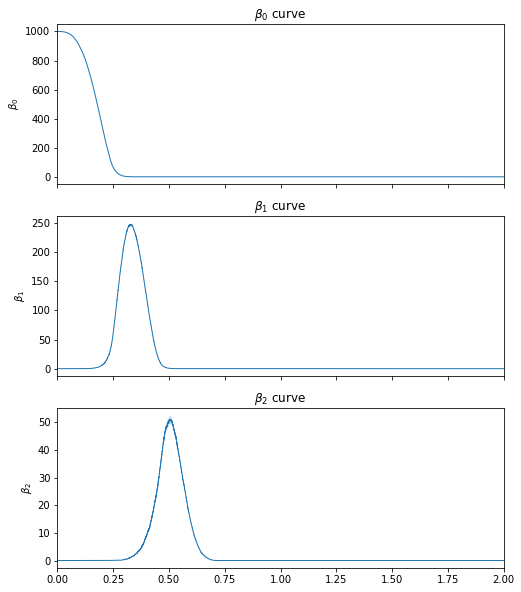

In [8]:
view_curves(CMC_bmcs_1000, CMC_std_bmcs_1000)

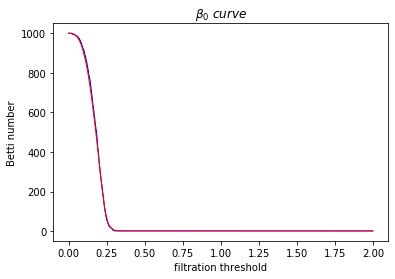

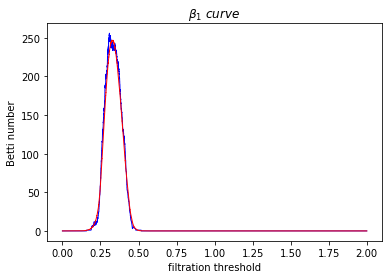

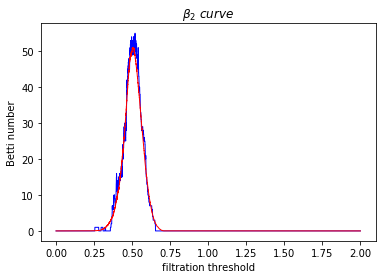

In [14]:
bcs_1000 = np.load('../output/data/sphere_1000_s_0_bcs.npy')
ts = np.linspace(0, max_threshold, (int(max_threshold / dt) + 1))

plt.figure(0)
plt.plot(ts, bcs_1000[0], linewidth=1, color='blue')
plt.plot(ts, CMC_bmcs_1000[0], linewidth=1, color='red')

plt.figure(1)  
plt.plot(ts, bcs_1000[1], linewidth=1, color='blue')
plt.plot(ts, CMC_bmcs_1000[1], linewidth=1, color='red')

plt.figure(2)  
plt.plot(ts, bcs_1000[2], linewidth=1, color='blue')
plt.plot(ts, CMC_bmcs_1000[2], linewidth=1, color='red')
        

for dim in range(0, (max_dim + 1)):
    plt.figure(dim)

    plt.xlabel('filtration threshold')
    plt.ylabel('Betti number')
    plt.title(r'$\beta_{} \ curve$'.format(dim))

In [10]:
def view_curves_error_bars(bmcs, std_bmcs):
    _bmc_0, _bmc_1, _bmc_2 = bmcs
    _std_bmc_0, _std_bmc_1, _std_bmc_2 = std_bmcs
    
    ts = np.linspace(0, max_threshold, (int(max_threshold / dt) + 1))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,10))

    ax1.plot(ts, _bmc_0, linewidth=1)
    ax1.fill_between(ts, np.maximum(_bmc_0 - _std_bmc_0, 0), _bmc_0 + _std_bmc_0, alpha=0.25)
    ax1.set_ylabel(r'$\beta_0$')
    ax1.set_title(r'$\beta_0$ curve')
    ax1.set_xlim([0, 2])

    ax2.plot(ts, _bmc_1, linewidth=1)
    ax2.fill_between(ts, np.maximum(_bmc_1 - _std_bmc_1, 0), _bmc_1 + _std_bmc_1, alpha=0.25)
    ax2.set_ylabel(r'$\beta_1$')
    ax2.set_title(r'$\beta_1$ curve')
    ax2.set_xlim([0, 2])

    ax3.plot(ts, _bmc_2, linewidth=1)
    ax3.fill_between(ts, np.maximum(_bmc_2 - _std_bmc_2, 0), _bmc_2 + _std_bmc_2, alpha=0.25)
    ax3.set_ylabel(r'$\beta_2$')
    ax3.set_title(r'$\beta_2$ curve')
    ax3.set_xlim([0, 2])

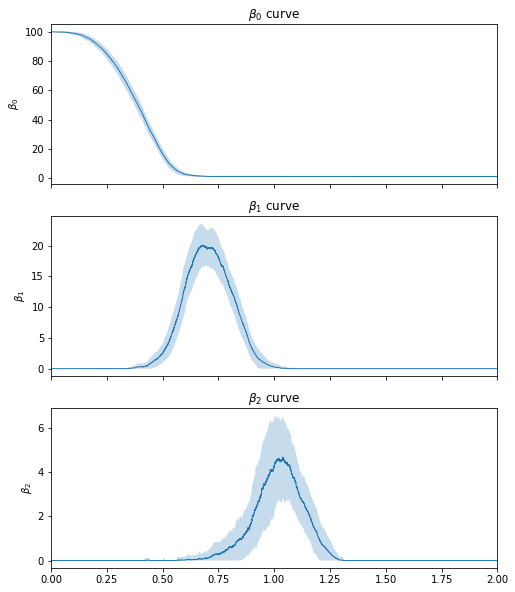

In [11]:
view_curves_error_bars([CMC_betti_mean_curve_0, CMC_betti_mean_curve_1, CMC_betti_mean_curve_2], [CMC_std_betti_mean_curve_0, CMC_std_betti_mean_curve_1, CMC_std_betti_mean_curve_2])

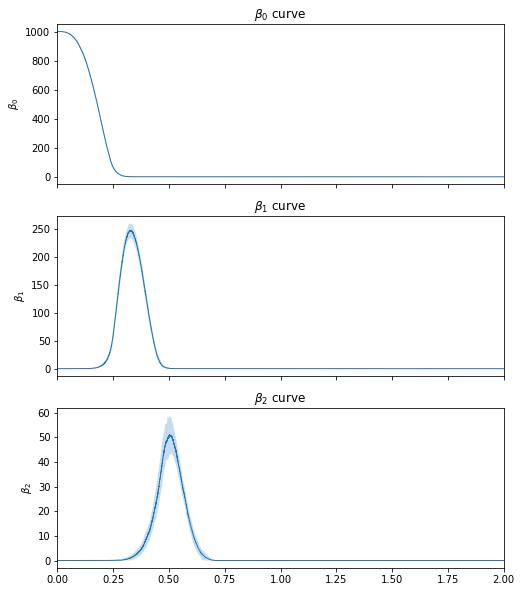

In [12]:
view_curves_error_bars(CMC_bmcs_1000, CMC_std_bmcs_1000)

C:\Users\arthu\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\arthu\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


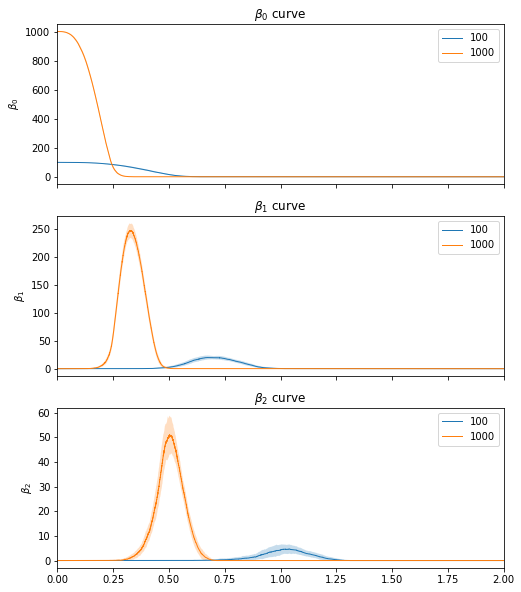

In [13]:
_bmc_0, _bmc_1, _bmc_2 = [CMC_betti_mean_curve_0, CMC_betti_mean_curve_1, CMC_betti_mean_curve_2]
_bmc_0_, _bmc_1_, _bmc_2_ = CMC_bmcs_1000
_std_bmc_0, _std_bmc_1, _std_bmc_2 = [CMC_std_betti_mean_curve_0, CMC_std_betti_mean_curve_1, CMC_std_betti_mean_curve_2]
_std_bmc_0_, _std_bmc_1_, _std_bmc_2_ = CMC_std_bmcs_1000

ts = np.linspace(0, max_threshold, (int(max_threshold / dt) + 1))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,10))

ax1.plot(ts, _bmc_0, linewidth=1, label='100')
ax1.fill_between(ts, np.maximum(_bmc_0 - _std_bmc_0, 0), _bmc_0 + _std_bmc_0, alpha=0.25)
ax1.plot(ts, _bmc_0_, linewidth=1, label='1000')
ax1.fill_between(ts, np.maximum(_bmc_0_ - _std_bmc_0_, 0), _bmc_0_ + _std_bmc_0_, alpha=0.25)
ax1.set_ylabel(r'$\beta_0$')
ax1.set_title(r'$\beta_0$ curve')
ax1.set_xlim([0, 2])
ax1.legend()

ax2.plot(ts, _bmc_1, linewidth=1, label='100')
ax2.fill_between(ts, np.maximum(_bmc_1 - _std_bmc_1, 0), _bmc_1 + _std_bmc_1, alpha=0.25)
ax2.plot(ts, _bmc_1_, linewidth=1, label='1000')
ax2.fill_between(ts, np.maximum(_bmc_1_ - _std_bmc_1_, 0), _bmc_1_ + _std_bmc_1_, alpha=0.25)
ax2.set_ylabel(r'$\beta_1$')
ax2.set_title(r'$\beta_1$ curve')
ax2.set_xlim([0, 2])
ax2.legend()

ax3.plot(ts, _bmc_2, linewidth=1, label='100')
ax3.fill_between(ts, np.maximum(_bmc_2 - _std_bmc_2, 0), _bmc_2 + _std_bmc_2, alpha=0.25)
ax3.plot(ts, _bmc_2_, linewidth=1, label='1000')
ax3.fill_between(ts, np.maximum(_bmc_2_ - _std_bmc_2_, 0), _bmc_2_ + _std_bmc_2_, alpha=0.25)
ax3.set_ylabel(r'$\beta_2$')
ax3.set_title(r'$\beta_2$ curve')
ax3.set_xlim([0, 2])
ax3.legend()

## Independent CMC Estimation

We first compute the Betti curves on independently sampled datasets of various sizes ranging from 10 points to 49 points.

In [149]:
%%time

n = 100
max_dim = 2
max_threshold = 2
dt = 0.00001
ps = np.arange(10, 50)

bmcs_0 = []
bmcs_1 = []
bmcs_2 = []

std_bmcs_0 = []
std_bmcs_1 = []
std_bmcs_2 = []

for p in ps:

    _betti_curves_0 = []
    _betti_curves_1 = []
    _betti_curves_2 = []

    for i in range(n):
        # compute persistence
        full_matrix = utility.lower_matrix_txt_to_full_matrix('../data/sphere_3_100_s_{}.lower_distance_matrix'.format(i), 100)
        persistence_ripser = ripser.ripser(full_matrix[0:p,0:p], maxdim=max_dim, distance_matrix=True)

        # compute betti curves
        _betti_curves = statistics.betti_curves(persistence_ripser, dt, max_threshold)
        _betti_curves_0.append(_betti_curves[0])
        _betti_curves_1.append(_betti_curves[1])
        _betti_curves_2.append(_betti_curves[2])

    bmcs_0.append(np.mean(np.array(_betti_curves_0), axis=0))
    bmcs_1.append(np.mean(np.array(_betti_curves_1), axis=0))
    bmcs_2.append(np.mean(np.array(_betti_curves_2), axis=0))
    
    std_bmcs_0.append(np.std(np.array(_betti_curves_0), axis=0))
    std_bmcs_1.append(np.std(np.array(_betti_curves_1), axis=0))
    std_bmcs_2.append(np.std(np.array(_betti_curves_2), axis=0))

Wall time: 1min 48s


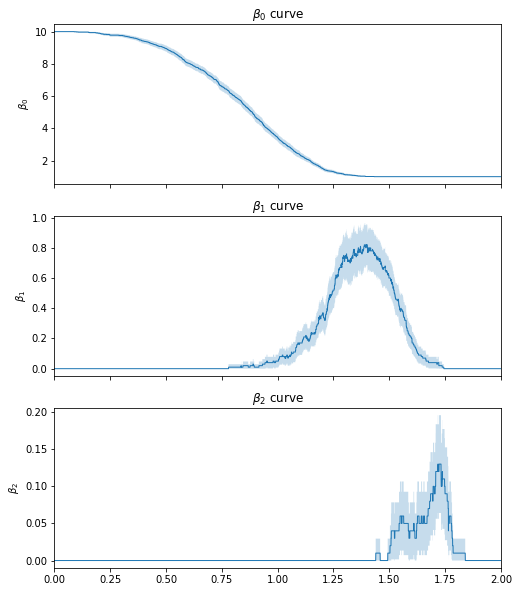

In [150]:
view_curves([bmcs_0[0], bmcs_1[0], bmcs_2[0]], [std_bmcs_0[0], std_bmcs_1[0], std_bmcs_2[0]])

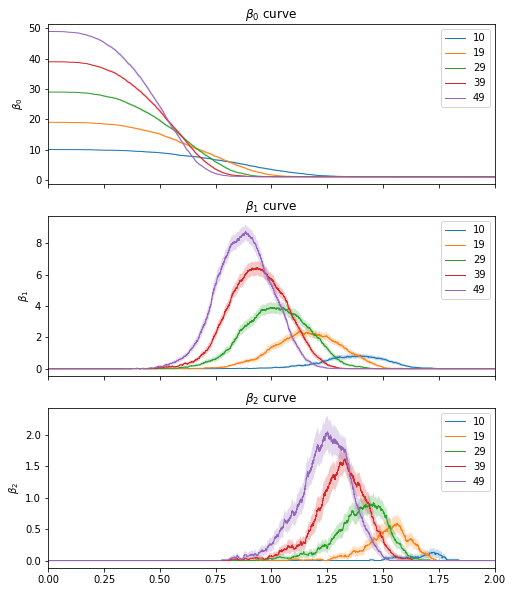

In [151]:
ts = np.linspace(0, max_threshold, (int(max_threshold / dt) + 1))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,10))

for i in [0, 9, 19, 29, 39]:
    ax1.plot(ts, bmcs_0[i], linewidth=1, label=ps[i])
    ax1.fill_between(ts, np.maximum(bmcs_0[i] - 1.96*std_bmcs_0[i]/np.sqrt(n), 0), bmcs_0[i] + 1.96*std_bmcs_0[i]/np.sqrt(n), alpha=0.25)
ax1.set_ylabel(r'$\beta_0$')
ax1.set_title(r'$\beta_0$ curve')
ax1.set_xlim([0, 1])
ax1.legend()


for i in [0, 9, 19, 29, 39]:
    ax2.plot(ts, bmcs_1[i], linewidth=1, label=ps[i])
    ax2.fill_between(ts, np.maximum(bmcs_1[i] - 1.96*std_bmcs_1[i]/np.sqrt(n), 0), bmcs_1[i] + 1.96*std_bmcs_1[i]/np.sqrt(n), alpha=0.25)
ax2.set_ylabel(r'$\beta_1$')
ax2.set_title(r'$\beta_1$ curve')
ax2.set_xlim([0, 2])
ax2.legend()

for i in [0, 9, 19, 29, 39]:
    ax3.plot(ts, bmcs_2[i], linewidth=1, label=ps[i])
    ax3.fill_between(ts, np.maximum(bmcs_2[i] - 1.96*std_bmcs_2[i]/np.sqrt(n), 0), bmcs_2[i] + 1.96*std_bmcs_2[i]/np.sqrt(n), alpha=0.25)
ax3.set_ylabel(r'$\beta_2$')
ax3.set_title(r'$\beta_2$ curve')
ax3.set_xlim([0, 2])
ax3.legend()

Using our Betti curves for each dataset sizes, we now try to predict the parameters for some parametric estimation of the curves on a dataset size of 100 points.

In [152]:
def predict_betti_0_curve(ps, sampled_0_curves, prediction_n):
    As = []
    Cs = []
    for i, p in enumerate(ps):
        parameters, covariance = curve_fit(sigmoid, ts, sampled_0_curves[i], bounds=(0, [np.inf, p, 2]))
        As.append(parameters[0])
        Cs.append(parameters[2])
        
    parameters_A, covariance = curve_fit(logarithm, ps, As, bounds=(0, [np.inf, np.inf, np.inf]))
    parameters_C, covariance = curve_fit(inv, ps, Cs, bounds=([0, 1, 0], [1, np.inf, np.inf]))
    
    A_predicted = logarithm(prediction_n, parameters_A[0], parameters_A[1], parameters_A[2])
    B_predicted = prediction_n - 1
    C_predicted = inv(prediction_n, parameters_C[0], parameters_C[1], parameters_C[2])
    
    return A_predicted, B_predicted, C_predicted

def predict_betti_d_curve(ps, sampled_d_curves, prediction_n):
    Ds = []
    Es = []
    Fs = []
    for i, p in enumerate(ps):
        parameters, covariance = curve_fit(new_gaussian, ts, sampled_d_curves[i], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
        Ds.append(parameters[0])
        Es.append(parameters[1])
        Fs.append(parameters[2])
        
    parameters_D, covariance = curve_fit(logarithm, ps, Ds, bounds=(0, np.inf))
    parameters_E, covariance = curve_fit(inv, ps, Es, bounds=([0, 1, 1], [1, 10, 2]))
    parameters_F, covariance = curve_fit(inv, ps, Fs, bounds=([0, 1, 1], [1, 10, 2]))
    
    D_predicted = logarithm(prediction_n, parameters_D[0], parameters_D[1], parameters_D[2])
    E_predicted = inv(prediction_n, parameters_E[0], parameters_E[1], parameters_E[2])
    F_predicted = inv(prediction_n, parameters_F[0], parameters_F[1], parameters_F[2])
    
    return D_predicted, E_predicted, F_predicted

In [153]:
%%time

A, B, C = predict_betti_0_curve(ps, bmcs_0, 100)

Wall time: 31.6 s


In [154]:
plt.figure(0)
plt.plot(ts, sigmoid(ts, A, B, C), linewidth=1, label='estimated')
plt.plot(ts, CMC_betti_mean_curve_0, linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_betti_mean_curve_0 - 1.96*CMC_std_betti_mean_curve_0/np.sqrt(n), 0), CMC_betti_mean_curve_0 + 1.96*CMC_std_betti_mean_curve_0/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_0$')
plt.title(r'$\beta_0$ curve')
plt.xlim([0, 2])
plt.legend()

In [155]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_1, 100)

Wall time: 23 s


In [156]:
parameters, covariance = curve_fit(new_gaussian, ts, CMC_betti_mean_curve_1, bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_100 = parameters[0]
E_100 = parameters[1]
F_100 = parameters[2]

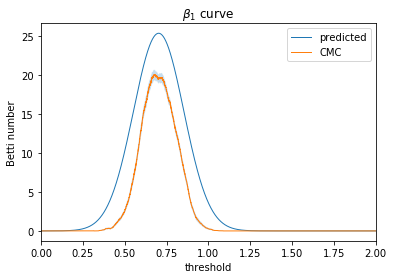

In [157]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='predicted')
plt.plot(ts, CMC_betti_mean_curve_1, linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_betti_mean_curve_1 - 1.96*CMC_std_betti_mean_curve_1/np.sqrt(n), 0), CMC_betti_mean_curve_1 + 1.96*CMC_std_betti_mean_curve_1/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'Betti number')
plt.title(r'$\beta_1$ curve')
plt.xlim([0, 2])
plt.legend()

In [158]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_2, 100)

Wall time: 35.9 s


In [159]:
parameters, covariance = curve_fit(new_gaussian, ts, CMC_betti_mean_curve_2, bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_100 = parameters[0]
E_100 = parameters[1]
F_100 = parameters[2]

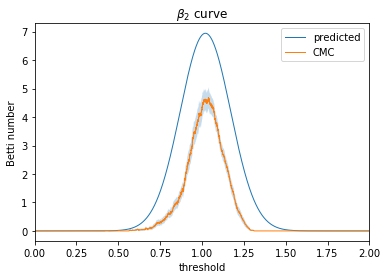

In [160]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='predicted')
plt.plot(ts, CMC_betti_mean_curve_2, linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_betti_mean_curve_2 - 1.96*CMC_std_betti_mean_curve_2/np.sqrt(n), 0), CMC_betti_mean_curve_2 + 1.96*CMC_std_betti_mean_curve_2/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'Betti number')
plt.title(r'$\beta_2$ curve')
plt.xlim([0, 2])
plt.legend()

Using our Betti curves for each dataset sizes, we now try to predict the parameters for some parametric estimation of the curves on a dataset size of 1000 points.

In [161]:
%%time

A, B, C = predict_betti_0_curve(ps, bmcs_0, 1000)

Wall time: 29.7 s


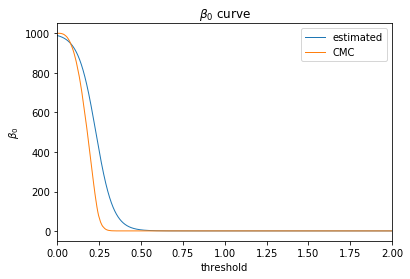

In [162]:
plt.figure(0)
plt.plot(ts, sigmoid(ts, A, B, C), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[0], linewidth=1, label='CMC')
plt.fill_between(ts, CMC_bmcs_1000[0], CMC_bmcs_1000[0], alpha=0)
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[0] - 1.96*CMC_std_bmcs_1000[0]/np.sqrt(n), 0), CMC_bmcs_1000[0] + 1.96*CMC_std_bmcs_1000[0]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_0$')
plt.title(r'$\beta_0$ curve')
plt.xlim([0, 2])
plt.legend()

In [163]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_1, 1000)

Wall time: 25 s


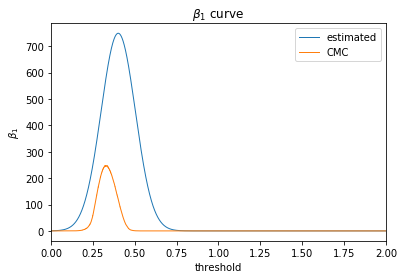

In [164]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[1], linewidth=1, label='CMC')
plt.fill_between(ts, CMC_bmcs_1000[1], CMC_bmcs_1000[1], alpha=0)
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[1] - 1.96*CMC_std_bmcs_1000[1]/np.sqrt(n), 0), CMC_bmcs_1000[1] + 1.96*CMC_std_bmcs_1000[1]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_1$')
plt.title(r'$\beta_1$ curve')
plt.xlim([0, 2])
plt.legend()

In [165]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_2, 1000)

Wall time: 34.3 s


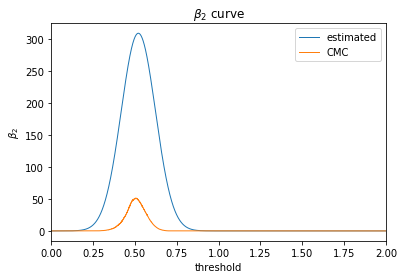

In [166]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[2], linewidth=1, label='CMC')
plt.fill_between(ts, CMC_bmcs_1000[2], CMC_bmcs_1000[2], alpha=0)
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[2] - 1.96*CMC_std_bmcs_1000[2]/np.sqrt(n), 0), CMC_bmcs_1000[2] + 1.96*CMC_std_bmcs_1000[2]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_2$')
plt.title(r'$\beta_2$ curve')
plt.xlim([0, 2])
plt.legend()

## Simple Bootstrap CMC Estimation

We first compute the Betti curves on boostrap datasets from one given 100 points dataset, with sizes ranging from 10 points to 49 points.

In [128]:
%%time

# bootstrap
full_matrix = utility.lower_matrix_txt_to_full_matrix('../data/sphere_3_100_s_{}.lower_distance_matrix'.format(0), 100)
l = full_matrix.shape[0]

n = 100
max_dim = 2
max_threshold = 2
dt = 0.00001
ps = np.arange(10, 50)

bmcs_0 = []
bmcs_1 = []
bmcs_2 = []

std_bmcs_0 = []
std_bmcs_1 = []
std_bmcs_2 = []

for p in ps:

    _betti_curves_0 = []
    _betti_curves_1 = []
    _betti_curves_2 = []

    for i in range(n):
        # compute persistence
        indices = np.array(random.choices(range(l), k=p))
        persistence_ripser = ripser.ripser(full_matrix[indices,:][:,indices], maxdim=max_dim, distance_matrix=True)

        # compute betti curves
        _betti_curves = statistics.betti_curves(persistence_ripser, dt, max_threshold)
        _betti_curves_0.append(_betti_curves[0])
        _betti_curves_1.append(_betti_curves[1])
        _betti_curves_2.append(_betti_curves[2])

    bmcs_0.append(np.mean(np.array(_betti_curves_0), axis=0))
    bmcs_1.append(np.mean(np.array(_betti_curves_1), axis=0))
    bmcs_2.append(np.mean(np.array(_betti_curves_2), axis=0))
    
    std_bmcs_0.append(np.std(np.array(_betti_curves_0), axis=0))
    std_bmcs_1.append(np.std(np.array(_betti_curves_1), axis=0))
    std_bmcs_2.append(np.std(np.array(_betti_curves_2), axis=0))

Wall time: 56.2 s


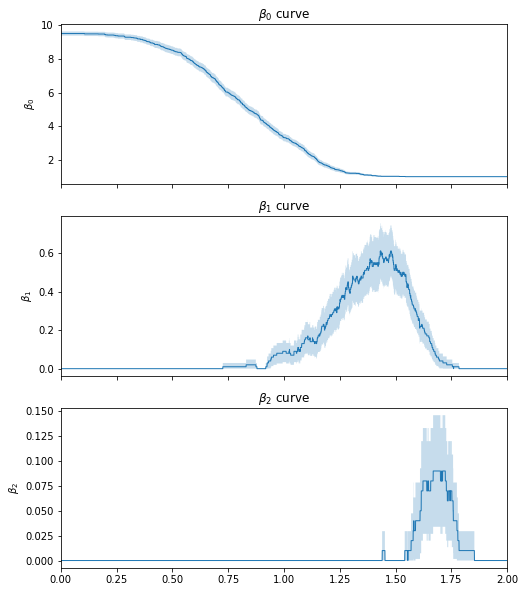

In [129]:
view_curves([bmcs_0[0], bmcs_1[0], bmcs_2[0]], [std_bmcs_0[0], std_bmcs_1[0], std_bmcs_2[0]])

In [130]:
ts = np.linspace(0, max_threshold, (int(max_threshold / dt) + 1))

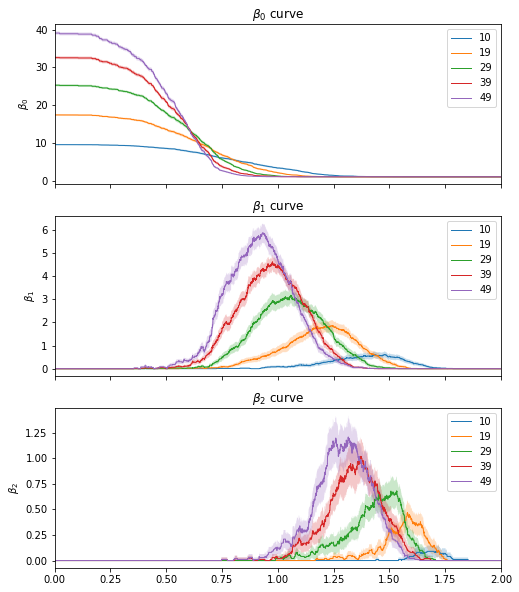

In [131]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,10))

for i in [0, 9, 19, 29, 39]:
    ax1.plot(ts, bmcs_0[i], linewidth=1, label=ps[i])
    ax1.fill_between(ts, np.maximum(bmcs_0[i] - 1.96*std_bmcs_0[i]/np.sqrt(n), 0), bmcs_0[i] + 1.96*std_bmcs_0[i]/np.sqrt(n), alpha=0.25)
ax1.set_ylabel(r'$\beta_0$')
ax1.set_title(r'$\beta_0$ curve')
ax1.set_xlim([0, 2])
ax1.legend()

for i in [0, 9, 19, 29, 39]:
    ax2.plot(ts, bmcs_1[i], linewidth=1, label=ps[i])
    ax2.fill_between(ts, np.maximum(bmcs_1[i] - 1.96*std_bmcs_1[i]/np.sqrt(n), 0), bmcs_1[i] + 1.96*std_bmcs_1[i]/np.sqrt(n), alpha=0.25)
ax2.set_ylabel(r'$\beta_1$')
ax2.set_title(r'$\beta_1$ curve')
ax2.set_xlim([0, 2])
ax2.legend()

for i in [0, 9, 19, 29, 39]:
    ax3.plot(ts, bmcs_2[i], linewidth=1, label=ps[i])
    ax3.fill_between(ts, np.maximum(bmcs_2[i] - 1.96*std_bmcs_2[i]/np.sqrt(n), 0), bmcs_2[i] + 1.96*std_bmcs_2[i]/np.sqrt(n), alpha=0.25)
ax3.set_ylabel(r'$\beta_2$')
ax3.set_title(r'$\beta_2$ curve')
ax3.set_xlim([0, 2])
ax3.legend()

Using our Betti curves for each dataset sizes, we now try to predict the parameters for some parametric estimation of the curves on a dataset size of 100 points.

In [132]:
%%time

A, B, C = predict_betti_0_curve(ps, bmcs_0, 100)

Wall time: 16.4 s


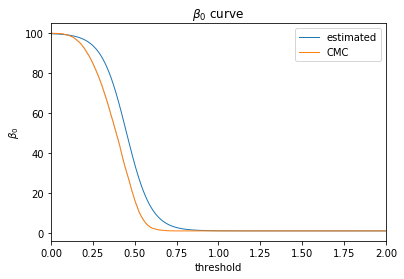

In [133]:
plt.figure(0)
plt.plot(ts, sigmoid(ts, A, B, C), linewidth=1, label='estimated')
plt.plot(ts, CMC_betti_mean_curve_0, linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_betti_mean_curve_0 - 1.96*CMC_std_betti_mean_curve_0/np.sqrt(n), 0), CMC_betti_mean_curve_0 + 1.96*CMC_std_betti_mean_curve_0/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_0$')
plt.title(r'$\beta_0$ curve')
plt.xlim([0, 2])
plt.legend()

In [145]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_1, 100)

Wall time: 15.4 s


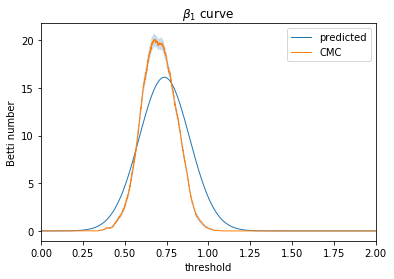

In [146]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='predicted')
plt.plot(ts, CMC_betti_mean_curve_1, linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_betti_mean_curve_1 - 1.96*CMC_std_betti_mean_curve_1/np.sqrt(n), 0), CMC_betti_mean_curve_1 + 1.96*CMC_std_betti_mean_curve_1/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'Betti number')
plt.title(r'$\beta_1$ curve')
plt.xlim([0, 2])
plt.legend()

In [136]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_2, 100)

Wall time: 23.8 s


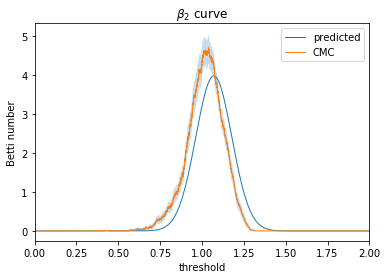

In [137]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='predicted')
plt.plot(ts, CMC_betti_mean_curve_2, linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_betti_mean_curve_2 - 1.96*CMC_std_betti_mean_curve_2/np.sqrt(n), 0), CMC_betti_mean_curve_2 + 1.96*CMC_std_betti_mean_curve_2/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'Betti number')
plt.title(r'$\beta_2$ curve')
plt.xlim([0, 2])
plt.legend()

For 1000 points

In [138]:
%%time

A, B, C = predict_betti_0_curve(ps, bmcs_0, 1000)

Wall time: 18.8 s


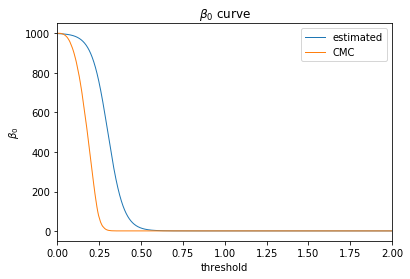

In [139]:
plt.figure(0)
plt.plot(ts, sigmoid(ts, A, B, C), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[0], linewidth=1, label='CMC')
plt.fill_between(ts, CMC_bmcs_1000[0], CMC_bmcs_1000[0], alpha=0)
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[0] - 1.96*CMC_std_bmcs_1000[0]/np.sqrt(n), 0), CMC_bmcs_1000[0] + 1.96*CMC_std_bmcs_1000[0]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_0$')
plt.title(r'$\beta_0$ curve')
plt.xlim([0, 2])
plt.legend()

In [147]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_1, 1000)

Wall time: 17.2 s


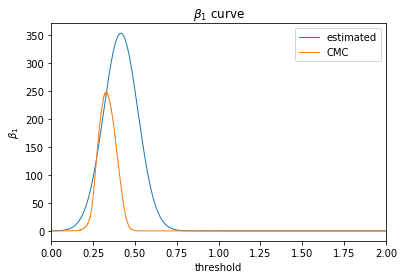

In [148]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[1], linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[1] - 1.96*CMC_std_bmcs_1000[1]/np.sqrt(n), 0), CMC_bmcs_1000[1] + 1.96*CMC_std_bmcs_1000[1]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_1$')
plt.title(r'$\beta_1$ curve')
plt.xlim([0, 2])
plt.legend()

In [142]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_2, 1000)

Wall time: 28.5 s


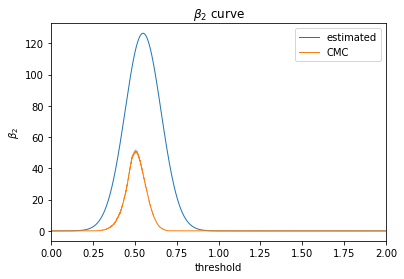

In [143]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[2], linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[2] - 1.96*CMC_std_bmcs_1000[2]/np.sqrt(n), 0), CMC_bmcs_1000[2] + 1.96*CMC_std_bmcs_1000[2]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_2$')
plt.title(r'$\beta_2$ curve')
plt.xlim([0, 2])
plt.legend()

## Larger Bootstrap CMC Estimation

We first compute the Betti curves on boostrap datasets from one given larger 1000 points dataset, with sizes ranging from 10 to 49 points.

In [15]:
%%time

# bootstrap
full_matrix = utility.lower_matrix_txt_to_full_matrix('../output/data/sphere_1000_s_{}.lower_distance_matrix'.format(0), 1000)
l = full_matrix.shape[0]

n = 100
max_dim = 2
max_threshold = 2
dt = 0.00001
ps = np.arange(10, 50)

bmcs_0 = []
bmcs_1 = []
bmcs_2 = []

for p in ps:

    _betti_curves_0 = []
    _betti_curves_1 = []
    _betti_curves_2 = []

    for i in range(n):
        # compute persistence
        indices = np.array(random.choices(range(l), k=p))
        persistence_ripser = ripser.ripser(full_matrix[indices,:][:,indices], maxdim=max_dim, distance_matrix=True)

        # compute betti curves
        _betti_curves = statistics.betti_curves(persistence_ripser, dt, max_threshold)
        _betti_curves_0.append(_betti_curves[0])
        _betti_curves_1.append(_betti_curves[1])
        _betti_curves_2.append(_betti_curves[2])

    bmcs_0.append(np.mean(np.array(_betti_curves_0), axis=0))
    bmcs_1.append(np.mean(np.array(_betti_curves_1), axis=0))
    bmcs_2.append(np.mean(np.array(_betti_curves_2), axis=0))

Wall time: 56.3 s


In [19]:
%%time

A, B, C = predict_betti_0_curve(ps, bmcs_0, 1000)

Wall time: 33.3 s


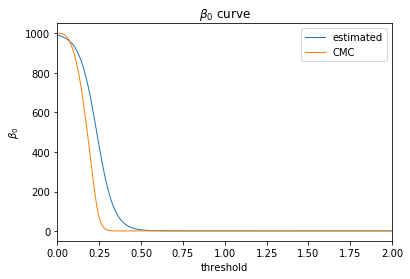

In [20]:
plt.figure(0)
plt.plot(ts, sigmoid(ts, A, B, C), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[0], linewidth=1, label='CMC')
plt.fill_between(ts, CMC_bmcs_1000[0], CMC_bmcs_1000[0], alpha=0)
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[0] - 1.96*CMC_std_bmcs_1000[0]/np.sqrt(n), 0), CMC_bmcs_1000[0] + 1.96*CMC_std_bmcs_1000[0]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_0$')
plt.title(r'$\beta_0$ curve')
plt.xlim([0, 2])
plt.legend()

In [21]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_1, 1000)

Wall time: 25.2 s


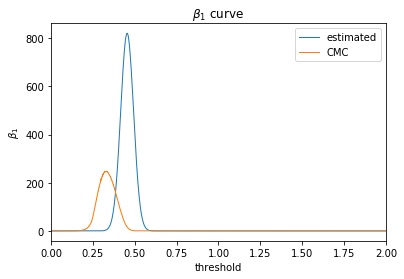

In [22]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[1], linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[1] - 1.96*CMC_std_bmcs_1000[1]/np.sqrt(n), 0), CMC_bmcs_1000[1] + 1.96*CMC_std_bmcs_1000[1]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_1$')
plt.title(r'$\beta_1$ curve')
plt.xlim([0, 2])
plt.legend()

In [23]:
%%time

D, E, F = predict_betti_d_curve(ps, bmcs_2, 1000)

Wall time: 38.3 s


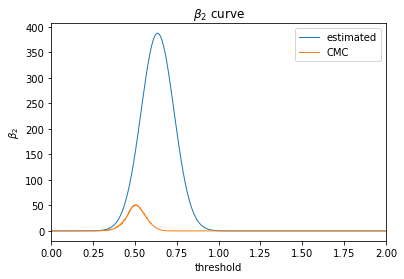

In [24]:
plt.figure(0)
plt.plot(ts, new_gaussian(ts, D, E, F), linewidth=1, label='estimated')
plt.plot(ts, CMC_bmcs_1000[2], linewidth=1, label='CMC')
plt.fill_between(ts, np.maximum(CMC_bmcs_1000[2] - 1.96*CMC_std_bmcs_1000[2]/np.sqrt(n), 0), CMC_bmcs_1000[2] + 1.96*CMC_std_bmcs_1000[2]/np.sqrt(n), alpha=0.25)
plt.xlabel('threshold')
plt.ylabel(r'$\beta_2$')
plt.title(r'$\beta_2$ curve')
plt.xlim([0, 2])
plt.legend()

## Parameters Trends

In [398]:
%%time

n = 100
max_dim = 2
max_threshold = 2
dt = 0.00001
ps = np.arange(10, 50)

bmcs_0 = []
bmcs_1 = []
bmcs_2 = []

std_bmcs_0 = []
std_bmcs_1 = []
std_bmcs_2 = []

for p in ps:

    _betti_curves_0 = []
    _betti_curves_1 = []
    _betti_curves_2 = []

    for i in range(n):
        # compute persistence
        full_matrix = utility.lower_matrix_txt_to_full_matrix('../data/sphere_3_100_s_{}.lower_distance_matrix'.format(i), 100)
        persistence_ripser = ripser.ripser(full_matrix[0:p,0:p], maxdim=max_dim, distance_matrix=True)

        # compute betti curves
        _betti_curves = statistics.betti_curves(persistence_ripser, dt, max_threshold)
        _betti_curves_0.append(_betti_curves[0])
        _betti_curves_1.append(_betti_curves[1])
        _betti_curves_2.append(_betti_curves[2])

    bmcs_0.append(np.mean(np.array(_betti_curves_0), axis=0))
    bmcs_1.append(np.mean(np.array(_betti_curves_1), axis=0))
    bmcs_2.append(np.mean(np.array(_betti_curves_2), axis=0))
    
    std_bmcs_0.append(np.std(np.array(_betti_curves_0), axis=0))
    std_bmcs_1.append(np.std(np.array(_betti_curves_1), axis=0))
    std_bmcs_2.append(np.std(np.array(_betti_curves_2), axis=0))

Wall time: 1min 23s


In [399]:
parameters, covariance = curve_fit(sigmoid, ts, CMC_betti_mean_curve_0, bounds=(0, [np.inf, 100, np.inf]))
A_100 = parameters[0]
B_100 = parameters[1]
C_100 = parameters[2]

parameters, covariance = curve_fit(sigmoid, ts, CMC_bmcs_1000[0], bounds=([0, 0, 0], [np.inf, 1000, np.inf]))
A_1000 = parameters[0]
B_1000 = parameters[1]
C_1000 = parameters[2]

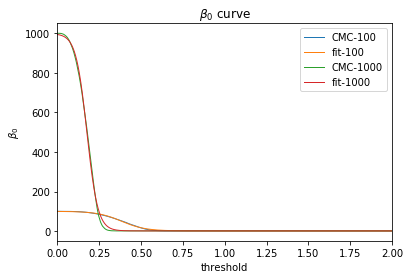

In [400]:
plt.figure(0)
plt.plot(ts, CMC_betti_mean_curve_0, linewidth=1, label='CMC-100')
plt.plot(ts, sigmoid(ts, A_100, B_100, C_100), linewidth=1, label='fit-100')
plt.plot(ts, CMC_bmcs_1000[0], linewidth=1, label='CMC-1000')
plt.plot(ts, sigmoid(ts, A_1000, B_1000, C_1000), linewidth=1, label='fit-1000')
plt.xlabel('threshold')
plt.ylabel(r'$\beta_0$')
plt.title(r'$\beta_0$ curve')
plt.xlim([0, 2])
plt.legend()

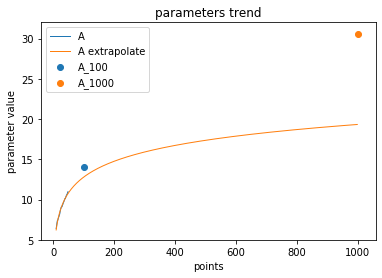

In [401]:
As = []
Cs = []
for i, p in enumerate(ps):
    parameters, covariance = curve_fit(sigmoid, ts, bmcs_0[i], bounds=(0, [np.inf, np.inf, np.inf]))
    As.append(parameters[0])
    Cs.append(parameters[2])

parameters_A, covariance = curve_fit(logarithm, ps, As, bounds=(0, [np.inf, np.inf, np.inf]))
parameters_C, covariance = curve_fit(inv, ps, Cs, bounds=([0, 1, 0], [1, np.inf, np.inf]))

plt.figure(0)
plt.plot(ps, As, linewidth=1, label='A')
plt.plot(np.arange(10, 1000), logarithm(np.arange(10, 1000), parameters_A[0], parameters_A[1], parameters_A[2]), linewidth=1, label='A extrapolate')
plt.scatter(100, A_100, label='A_100')
plt.scatter(1000, A_1000, label='A_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(1)
plt.plot(ps, Cs, linewidth=1, label='C')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_C[0], parameters_C[1], parameters_C[2]), linewidth=1, label='C extrapolate')
plt.scatter(100, C_100, label='C_100')
plt.scatter(1000, C_1000, label='C_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

In [402]:
parameters, covariance = curve_fit(new_gaussian, ts, CMC_betti_mean_curve_1, bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_100 = parameters[0]
E_100 = parameters[1]
F_100 = parameters[2]

parameters, covariance = curve_fit(new_gaussian, ts, CMC_bmcs_1000[1], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_1000 = parameters[0]
E_1000 = parameters[1]
F_1000 = parameters[2]

In [403]:
plt.figure(0)
plt.plot(ts, CMC_betti_mean_curve_1, linewidth=1, label='CMC-100')
plt.plot(ts, new_gaussian(ts, D_100, E_100, F_100), linewidth=1, label='fit-100')
plt.plot(ts, CMC_bmcs_1000[1], linewidth=1, label='CMC-1000')
plt.plot(ts, new_gaussian(ts, D_1000, E_1000, F_1000), linewidth=1, label='fit-1000')
plt.xlabel('threshold')
plt.ylabel(r'$\beta_1$')
plt.title(r'$\beta_1$ curve')
plt.xlim([0, 2])
plt.legend()

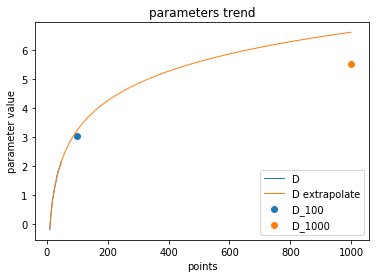

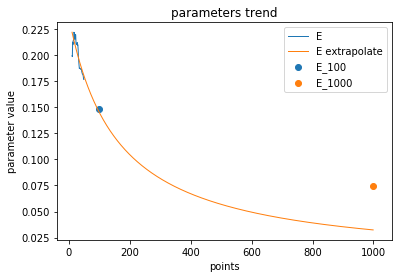

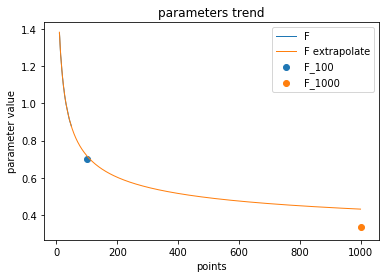

In [404]:
Ds = []
Es = []
Fs = []
for i, p in enumerate(ps):
    parameters, covariance = curve_fit(new_gaussian, ts, bmcs_1[i], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
    Ds.append(parameters[0])
    Es.append(parameters[1])
    Fs.append(parameters[2])
    
parameters_D, covariance = curve_fit(logarithm, ps, Ds, bounds=(0, np.inf))
parameters_E, covariance = curve_fit(inv, ps, Es, bounds=([0, 1, 0], [1, np.inf, np.inf]))
parameters_F, covariance = curve_fit(inv, ps, Fs, bounds=([0, 1, 0], [1, np.inf, np.inf]))

plt.figure(0)
plt.plot(ps, Ds, linewidth=1, label='D')
plt.plot(np.arange(10, 1000), logarithm(np.arange(10, 1000), parameters_D[0], parameters_D[1], parameters_D[2]), linewidth=1, label='D extrapolate')
plt.scatter(100, D_100, label='D_100')
plt.scatter(1000, D_1000, label='D_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(1)
plt.plot(ps, Es, linewidth=1, label='E')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_E[0], parameters_E[1], parameters_E[2]), linewidth=1, label='E extrapolate')
plt.scatter(100, E_100, label='E_100')
plt.scatter(1000, E_1000, label='E_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(2)
plt.plot(ps, Fs, linewidth=1, label='F')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_F[0], parameters_F[1], parameters_F[2]), linewidth=1, label='F extrapolate')
plt.scatter(100, F_100, label='F_100')
plt.scatter(1000, F_1000, label='F_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

In [405]:
parameters, covariance = curve_fit(new_gaussian, ts, CMC_betti_mean_curve_2, bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_100 = parameters[0]
E_100 = parameters[1]
F_100 = parameters[2]

parameters, covariance = curve_fit(new_gaussian, ts, CMC_bmcs_1000[2], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_1000 = parameters[0]
E_1000 = parameters[1]
F_1000 = parameters[2]

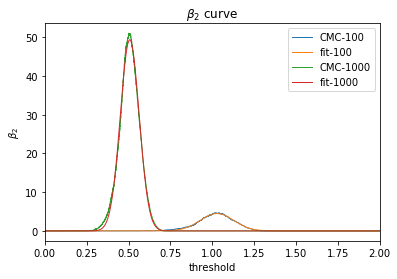

In [406]:
plt.figure(0)
plt.plot(ts, CMC_betti_mean_curve_2, linewidth=1, label='CMC-100')
plt.plot(ts, new_gaussian(ts, D_100, E_100, F_100), linewidth=1, label='fit-100')
plt.plot(ts, CMC_bmcs_1000[2], linewidth=1, label='CMC-1000')
plt.plot(ts, new_gaussian(ts, D_1000, E_1000, F_1000), linewidth=1, label='fit-1000')
plt.xlabel('threshold')
plt.ylabel(r'$\beta_2$')
plt.title(r'$\beta_2$ curve')
plt.xlim([0, 2])
plt.legend()

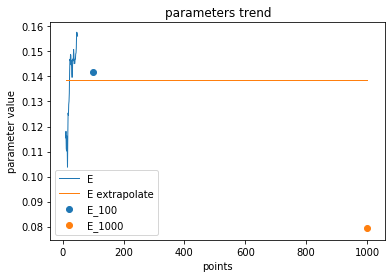

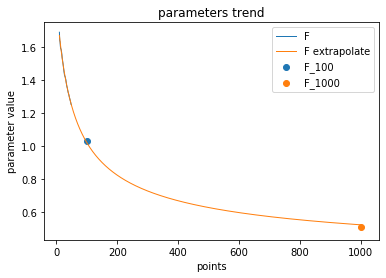

In [392]:
Ds = []
Es = []
Fs = []
for i, p in enumerate(ps):
    parameters, covariance = curve_fit(new_gaussian, ts, bmcs_2[i], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
    Ds.append(parameters[0])
    Es.append(parameters[1])
    Fs.append(parameters[2])
    
parameters_D, covariance = curve_fit(logarithm, ps, Ds, bounds=(0, np.inf))
parameters_E, covariance = curve_fit(inv, ps, Es, bounds=([0, 1, 0], [1, np.inf, np.inf]))
parameters_F, covariance = curve_fit(inv, ps, Fs, bounds=([0, 1, 0], [1, np.inf, np.inf]))

plt.figure(0)
plt.plot(ps, Ds, linewidth=1, label='D')
plt.plot(np.arange(10, 1000), logarithm(np.arange(10, 1000), parameters_D[0], parameters_D[1], parameters_D[2]), linewidth=1, label='D extrapolate')
plt.scatter(100, D_100, label='D_100')
plt.scatter(1000, D_1000, label='D_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(1)
plt.plot(ps, Es, linewidth=1, label='E')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_E[0], parameters_E[1], parameters_E[2]), linewidth=1, label='E extrapolate')
plt.scatter(100, E_100, label='E_100')
plt.scatter(1000, E_1000, label='E_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(2)
plt.plot(ps, Fs, linewidth=1, label='F')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_F[0], parameters_F[1], parameters_F[2]), linewidth=1, label='F extrapolate')
plt.scatter(100, F_100, label='F_100')
plt.scatter(1000, F_1000, label='F_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

In [424]:
%%time

# bootstrap
full_matrix = utility.lower_matrix_txt_to_full_matrix('../data/sphere_3_100_s_{}.lower_distance_matrix'.format(0), 100)
l = full_matrix.shape[0]

n = 100
max_dim = 2
max_threshold = 2
dt = 0.00001
ps = np.arange(10, 50)

bmcs_0 = []
bmcs_1 = []
bmcs_2 = []

for p in ps:

    _betti_curves_0 = []
    _betti_curves_1 = []
    _betti_curves_2 = []

    for i in range(n):
        # compute persistence
        indices = np.array(random.choices(range(l), k=p))
        persistence_ripser = ripser.ripser(full_matrix[indices,:][:,indices], maxdim=max_dim, distance_matrix=True)

        # compute betti curves
        _betti_curves = statistics.betti_curves(persistence_ripser, dt, max_threshold)
        _betti_curves_0.append(_betti_curves[0])
        _betti_curves_1.append(_betti_curves[1])
        _betti_curves_2.append(_betti_curves[2])

    bmcs_0.append(np.mean(np.array(_betti_curves_0), axis=0))
    bmcs_1.append(np.mean(np.array(_betti_curves_1), axis=0))
    bmcs_2.append(np.mean(np.array(_betti_curves_2), axis=0))

Wall time: 40.8 s


In [425]:
parameters, covariance = curve_fit(sigmoid, ts, CMC_betti_mean_curve_0, bounds=(0, [np.inf, 100, 2]))
A_100 = parameters[0]
B_100 = parameters[1]
C_100 = parameters[2]

parameters, covariance = curve_fit(sigmoid, ts, CMC_bmcs_1000[0], bounds=([0, 0, 0], [np.inf, 1000, 2]))
A_1000 = parameters[0]
B_1000 = parameters[1]
C_1000 = parameters[2]

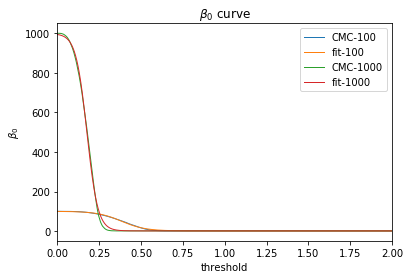

In [426]:
plt.figure(0)
plt.plot(ts, CMC_betti_mean_curve_0, linewidth=1, label='CMC-100')
plt.plot(ts, sigmoid(ts, A_100, B_100, C_100), linewidth=1, label='fit-100')
plt.plot(ts, CMC_bmcs_1000[0], linewidth=1, label='CMC-1000')
plt.plot(ts, sigmoid(ts, A_1000, B_1000, C_1000), linewidth=1, label='fit-1000')
plt.xlabel('threshold')
plt.ylabel(r'$\beta_0$')
plt.title(r'$\beta_0$ curve')
plt.xlim([0, 2])
plt.legend()

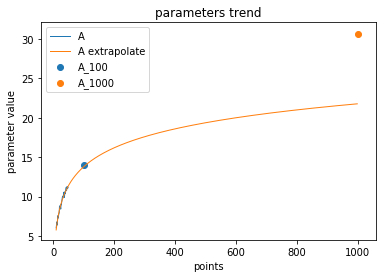

In [427]:
As = []
Cs = []
for i, p in enumerate(ps):
    parameters, covariance = curve_fit(sigmoid, ts, bmcs_0[i], bounds=(0, [np.inf, np.inf, np.inf]))
    As.append(parameters[0])
    Cs.append(parameters[2])

parameters_A, covariance = curve_fit(logarithm, ps, As, bounds=(0, [np.inf, np.inf, np.inf]))
parameters_C, covariance = curve_fit(inv, ps, Cs, bounds=([0, 1, 0], [1, np.inf, np.inf]))

plt.figure(0)
plt.plot(ps, As, linewidth=1, label='A')
plt.plot(np.arange(10, 1000), logarithm(np.arange(10, 1000), parameters_A[0], parameters_A[1], parameters_A[2]), linewidth=1, label='A extrapolate')
plt.scatter(100, A_100, label='A_100')
plt.scatter(1000, A_1000, label='A_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(1)
plt.plot(ps, Cs, linewidth=1, label='C')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_C[0], parameters_C[1], parameters_C[2]), linewidth=1, label='C extrapolate')
plt.scatter(100, C_100, label='C_100')
plt.scatter(1000, C_1000, label='C_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

In [428]:
parameters, covariance = curve_fit(new_gaussian, ts, CMC_betti_mean_curve_1, bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_100 = parameters[0]
E_100 = parameters[1]
F_100 = parameters[2]

parameters, covariance = curve_fit(new_gaussian, ts, CMC_bmcs_1000[1], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_1000 = parameters[0]
E_1000 = parameters[1]
F_1000 = parameters[2]

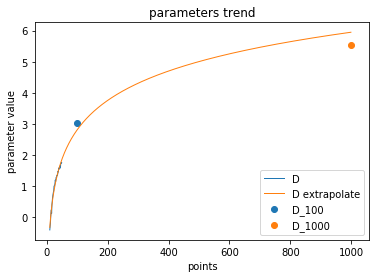

In [429]:
Ds = []
Es = []
Fs = []
for i, p in enumerate(ps):
    parameters, covariance = curve_fit(new_gaussian, ts, bmcs_1[i], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
    Ds.append(parameters[0])
    Es.append(parameters[1])
    Fs.append(parameters[2])
    
parameters_D, covariance = curve_fit(logarithm, ps, Ds, bounds=(0, np.inf))
parameters_E, covariance = curve_fit(inv, ps, Es, bounds=([0, 1, 0], [1, np.inf, np.inf]))
parameters_F, covariance = curve_fit(inv, ps, Fs, bounds=([0, 1, 0], [1, np.inf, np.inf]))

plt.figure(0)
plt.plot(ps, Ds, linewidth=1, label='D')
plt.plot(np.arange(10, 1000), logarithm(np.arange(10, 1000), parameters_D[0], parameters_D[1], parameters_D[2]), linewidth=1, label='D extrapolate')
plt.scatter(100, D_100, label='D_100')
plt.scatter(1000, D_1000, label='D_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(1)
plt.plot(ps, Es, linewidth=1, label='E')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_E[0], parameters_E[1], parameters_E[2]), linewidth=1, label='E extrapolate')
plt.scatter(100, E_100, label='E_100')
plt.scatter(1000, E_1000, label='E_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(2)
plt.plot(ps, Fs, linewidth=1, label='F')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_F[0], parameters_F[1], parameters_F[2]), linewidth=1, label='F extrapolate')
plt.scatter(100, F_100, label='F_100')
plt.scatter(1000, F_1000, label='F_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

In [430]:
parameters, covariance = curve_fit(new_gaussian, ts, CMC_betti_mean_curve_2, bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_100 = parameters[0]
E_100 = parameters[1]
F_100 = parameters[2]

parameters, covariance = curve_fit(new_gaussian, ts, CMC_bmcs_1000[2], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
D_1000 = parameters[0]
E_1000 = parameters[1]
F_1000 = parameters[2]

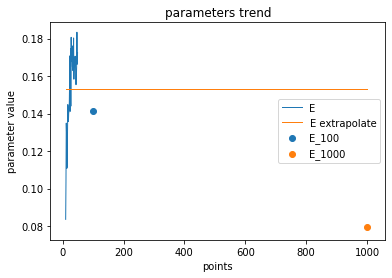

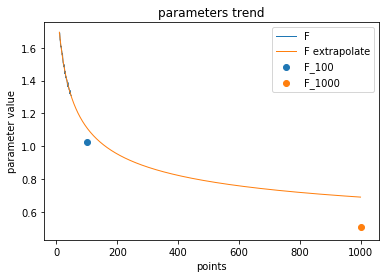

In [431]:
Ds = []
Es = []
Fs = []
for i, p in enumerate(ps):
    parameters, covariance = curve_fit(new_gaussian, ts, bmcs_2[i], bounds=([-np.inf, 0, 0], [np.inf, 2, 2]))
    Ds.append(parameters[0])
    Es.append(parameters[1])
    Fs.append(parameters[2])
    
parameters_D, covariance = curve_fit(logarithm, ps, Ds, bounds=(0, np.inf))
parameters_E, covariance = curve_fit(inv, ps, Es, bounds=([0, 1, 0], [1, np.inf, np.inf]))
parameters_F, covariance = curve_fit(inv, ps, Fs, bounds=([0, 1, 0], [1, np.inf, np.inf]))

plt.figure(0)
plt.plot(ps, Ds, linewidth=1, label='D')
plt.plot(np.arange(10, 1000), logarithm(np.arange(10, 1000), parameters_D[0], parameters_D[1], parameters_D[2]), linewidth=1, label='D extrapolate')
plt.scatter(100, D_100, label='D_100')
plt.scatter(1000, D_1000, label='D_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(1)
plt.plot(ps, Es, linewidth=1, label='E')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_E[0], parameters_E[1], parameters_E[2]), linewidth=1, label='E extrapolate')
plt.scatter(100, E_100, label='E_100')
plt.scatter(1000, E_1000, label='E_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()

plt.figure(2)
plt.plot(ps, Fs, linewidth=1, label='F')
plt.plot(np.arange(10, 1000), inv(np.arange(10, 1000), parameters_F[0], parameters_F[1], parameters_F[2]), linewidth=1, label='F extrapolate')
plt.scatter(100, F_100, label='F_100')
plt.scatter(1000, F_1000, label='F_1000')
plt.xlabel('points')
plt.ylabel('parameter value')
plt.title('parameters trend')
plt.legend()